In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt(
    '3wavelengths_try1.dat',
    skiprows=1,
    delimiter=','`
)

In [3]:
phoh, od_380, od_400, od_365 = data.T

### Outline of problem

lol we didnt outline the problem. 



In [4]:
con_N0 = 7.5 * 1e-6
eps_N_380 = od_380[0] / con_N0 
con_X = phoh

def con_NX(K1, K2):
    
    con = (
        K1 * con_N0 * con_X
        )/(
        1 + K1*con_X + K1*K2*con_X**2.
        )
    
    return con

def con_NX2(K1, K2):
    
    con = con_NX(K1, K2) * K2 * con_X
    
    return con
    

In [5]:
eps_N_380

26759.611085404536

In [6]:
def con_N(K1, K2):
    
    con = con_N0 - con_NX(K1, K2) - con_NX2(K1, K2)
    
    return con

In [7]:
np.hstack((con_N(1,1),con_N(1,1)))

array([7.50000000e-06, 7.27741843e-06, 7.06026059e-06, 6.84922958e-06,
       6.64482307e-06, 6.44736842e-06, 6.25705376e-06, 6.07395487e-06,
       5.89805825e-06, 5.72928052e-06, 5.56748466e-06, 5.19230769e-06,
       4.82728363e-06, 4.49437785e-06, 4.19148836e-06, 3.91623946e-06,
       3.66618721e-06, 3.43894644e-06, 3.23226398e-06, 3.04405630e-06,
       2.87242426e-06, 7.50000000e-06, 7.27741843e-06, 7.06026059e-06,
       6.84922958e-06, 6.64482307e-06, 6.44736842e-06, 6.25705376e-06,
       6.07395487e-06, 5.89805825e-06, 5.72928052e-06, 5.56748466e-06,
       5.19230769e-06, 4.82728363e-06, 4.49437785e-06, 4.19148836e-06,
       3.91623946e-06, 3.66618721e-06, 3.43894644e-06, 3.23226398e-06,
       3.04405630e-06, 2.87242426e-06])

In [13]:
def em_fun_at_380(unknowns):
    """ System of equations """
    K1, K2 = unknowns[:2]
    eps_NX = unknowns[2]#*1e5
    eps_NX2 = unknowns[3]#*1e4
    
    f = (
        eps_N_380 * con_N(K1, K2)
        + 
        eps_NX * con_NX(K1, K2) 
        +
        eps_NX2 * con_NX2(K1, K2)
        ) - od_380
    
    return f

In [24]:
def d_NX_d_K1(K1, K2):
    
    first_term = (
        con_N0 * con_X 
        * 
        (1 + K1*con_X + K1*K2*con_X**2.)**(-1.)
        )
    
    second_term = (
        K1 * con_N0 * con_X 
        *
        (-1)*(1 + K1*con_X + K1*K2*con_X**2.)**(-2.)
        *
        (con_X + K2*con_X**2.)
        )
    
    return first_term + second_term


def d_NX2_d_K1(K1, K2):
    
    return con_X * K2 * d_NX_d_K1(K1, K2) 


def d_NX_d_K2(K1, K2):
    
    der = (
        K1*con_N0*con_X
        *
        (-1)*(1 + K1*con_X + K1*K2*con_X**2.)**(-2.)
        *
        K1*con_X**2.
        )
    
    return der


def d_NX2_d_K2(K1, K2):
    
    der = con_X * (
        con_NX(K1, K2) 
        + 
        K2 * d_NX_d_K2(K1, K2)
        )
    
    return der


def d_N_d_K1(K1, K2):
    
    return -d_NX_d_K1(K1, K2) - d_NX2_d_K1(K1, K2)
    
    
def d_N_d_K2(K1, K2):
    
    return -d_NX_d_K2(K1, K2) - d_NX2_d_K2(K1, K2)


def jaco(unknowns):
    
    K1, K2 = unknowns[:2]
    eps_NX = unknowns[2]#*1e5
    eps_NX2 = unknowns[3]#*1e4
    
    ## Take derivitives with respect to K1
    ddk1 = (
        eps_N_380*d_N_d_K1(K1, K2)
        +
        eps_NX*d_NX_d_K1(K1, K2)
        +
        eps_NX2*d_NX2_d_K1(K1, K2)
        )
    
    ddk2 = (
        eps_N_380*d_N_d_K2(K1, K2)
        +
        eps_NX*d_NX_d_K2(K1, K2)
        +
        eps_NX2*d_NX2_d_K2(K1, K2)
        )
    
    ddepsNX = con_NX(K1, K2)
    
    ddepsNX2 = con_NX2(K1, K2)
    
    j = np.vstack((ddk1, ddk2, ddepsNX, ddepsNX2))
    
    return j.T

In [25]:
from scipy.optimize import Bounds

In [26]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

sol = opt.least_squares(
    em_fun_at_380, 
    ini_guess, 
#     jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [27]:
sol.success

True

In [28]:
sol

 active_mask: array([ 0,  0,  0, -1])
        cost: 0.00010986484678516483
         fun: array([ 0.        , -0.00633294, -0.00475546, -0.00141617,  0.00367149,
        0.00455645,  0.00431156,  0.00324973,  0.00137559,  0.00043335,
       -0.00179454, -0.00799151, -0.00343979, -0.00119496,  0.00049218,
        0.0016331 ,  0.00061278,  0.00167486,  0.00140605,  0.00016061,
       -0.00104628])
        grad: array([ 6.23554176e-11,  4.39075729e-11, -8.25903406e-16,  4.36736131e-10])
         jac: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.84277566e-02, -1.49674714e-03,  1.13785253e-06,
         1.49011612e-08],
       [ 2.72798682e-02, -6.51060417e-03,  1.95129871e-06,
         5.21540642e-08],
       [ 3.13695655e-02, -1.46982409e-02,  2.55417222e-06,
         1.04308128e-07],
       [ 3.29604390e-02, -2.52912194e-02,  3.01313854e-06,
         1.63912773e-07],
       [ 3.31982975e-02, -3.75661328e-02,  3.36978624e-06,
         2.235

In [29]:
def Absorbance_380(params):
    
    return em_fun_at_380(params)+od_380

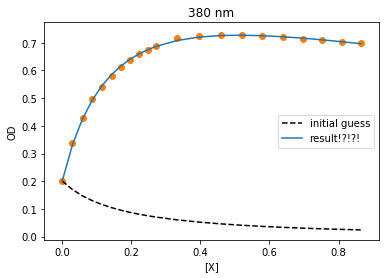

In [30]:

## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_380(ini_guess), 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_380(sol.x), label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_380, c='C1')
plt.title('380 nm')
plt.legend()


In [31]:
fit_params = sol.x

### Try with Jacobian

In [32]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1]

sol_jac = opt.least_squares(
    em_fun_at_380, 
    ini_guess, 
    jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [33]:
## Compare computed Jacobian at solution to analytic 
(sol.jac - jaco(sol.x))/(sol.jac)

C:\Users\emily\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[            nan,             nan,             nan,
                    nan],
       [ 2.21890330e-10, -1.14182090e-06, -2.02126580e-09,
        -4.70893063e-02],
       [ 7.75894613e-09, -3.50876941e-07, -3.67617577e-09,
        -1.60256146e-02],
       [-1.57661555e-08,  2.23860715e-08,  4.61594667e-09,
         1.22312491e-02],
       [-3.29989136e-08, -1.15970217e-07,  3.38483176e-10,
         2.07982408e-02],
       [-4.52540491e-08,  2.63442015e-07, -4.27314156e-09,
         5.71492832e-03],
       [-7.68108819e-09,  1.95334043e-07, -1.36590410e-08,
         1.48874931e-02],
       [ 2.71318470e-08,  4.96830146e-08,  3.73661874e-09,
        -3.00349057e-03],
       [-3.09190821e-08,  5.30784252e-08, -1.31762369e-10,
         2.16451597e-03],
       [ 2.35303059e-08, -3.65209274e-08, -3.41802837e-09,
         6.84441554e-03],
       [ 1.60333021e-09,  2.25901715e-08,  8.35661829e-09,
         1.19158259e-02],
       [ 9.74161291e-09, -4.14913610e-08, -2.68152890e-09,
      

In [34]:
## Compare resulting parameters
(sol.x - sol_jac.x)/sol.x

array([ 6.70901230e-09, -1.04595675e-08, -2.96369722e-09,  4.90330877e-01])

In [35]:
sol.x

array([6.03599347e+00, 4.61655459e-01, 1.42647084e+05, 9.56137502e-11])

In [36]:
sol_jac.x

array([6.03599343e+00, 4.61655464e-01, 1.42647084e+05, 4.87313762e-11])

# Multi wavelength...

In [38]:
## get eps_N for each wavelength 
eps_N_vec = np.array([od[0] for od in data.T[1:]])/con_N0

In [39]:

def em_fit_fun(unknowns):
    """ System of equations """
    K1, K2 = unknowns[:2]
    ## Check the length of eps_N_vec
        ## 2 * len(eps_N_vec) more unknowns
    
    ## Iterate through eps_N for each wavelength
    for i, eps_N in enumerate(eps_N_vec):
    
        ## Grab other two eps's from unknown arg (vector/list)
        ## eps_NX are odd indexed
        eps_NX = unknowns[2*(i+1)]
        ## eps_NX2s are even indexed
        eps_NX2 = unknowns[2*(i+1)+1]
        
        ## Build cost function for this wavelength 
        f = (
            eps_N * con_N(K1, K2)
            + 
            eps_NX * con_NX(K1, K2) 
            +
            eps_NX2 * con_NX2(K1, K2)
            ) - data.T[i+1]
        
        ## add value of cost funtion to list
        if i is 0:
            f_tot = f
        elif i is not 0:
            f_tot = np.hstack((f_tot, f))

    return f_tot

In [40]:
# ini_guess = [41.5, .06, 1.1, .25]
ini_guess_multi = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1,1.42647085e+00, 1,1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

fit_multi = opt.least_squares(
    em_fit_fun, 
    ini_guess_multi, 
#     jac=jaco, 
#     method='lm',
    bounds=(0, np.inf),
    x_scale='jac'
)


In [41]:
fit_multi

 active_mask: array([0, 0, 0, 0, 0, 0, 0, 0])
        cost: 0.0004066523983596253
         fun: array([ 0.00000000e+00, -7.52180703e-03, -5.66519140e-03, -1.71619859e-03,
        3.92440955e-03,  5.19447156e-03,  5.15805189e-03,  4.15430068e-03,
        2.22266769e-03,  1.14064149e-03, -1.28090229e-03, -8.05969189e-03,
       -4.10707341e-03, -2.30269602e-03, -8.32491468e-04,  3.34170481e-04,
       -4.23216389e-04,  1.12112286e-03,  1.53061505e-03,  1.13473925e-03,
        9.24492496e-04,  0.00000000e+00,  2.94721705e-03,  4.14564192e-03,
        4.54953660e-03,  4.87991982e-03,  4.39369833e-03,  3.38646691e-03,
        2.14911121e-03,  7.07498023e-04, -5.88596179e-04, -1.92083074e-03,
       -5.54935616e-03, -6.05992392e-03, -6.08543617e-03, -5.26501945e-03,
       -3.90565312e-03, -2.14881239e-03, -7.21622961e-05,  1.80256199e-03,
        5.10368956e-03,  8.31590714e-03,  0.00000000e+00,  1.98625143e-03,
        4.04851758e-03,  4.71944401e-03,  3.42866078e-03,  2.82317773e-03,
    

In [42]:
eps_N_vec.shape[0]

3

In [43]:
data.T[1:].shape

(3, 21)

In [44]:
def Absorbance_per_wavelength(params):
    
    n_wavelengths = eps_N_vec.shape[0]
    
    ## em_fit_fun is length = n_wavelengths * 21
    
    em_fit_array = em_fit_fun(params).reshape((n_wavelengths, 21))
    
    absorb = em_fit_array + data.T[1:]
    
    return absorb

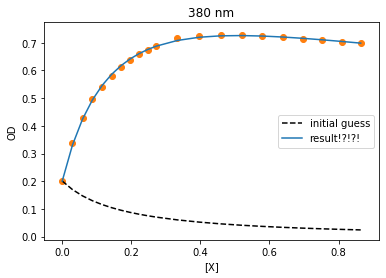

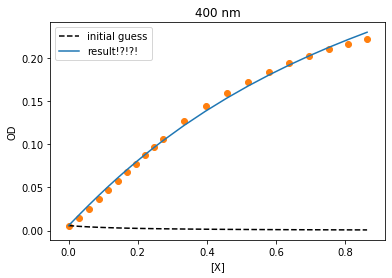

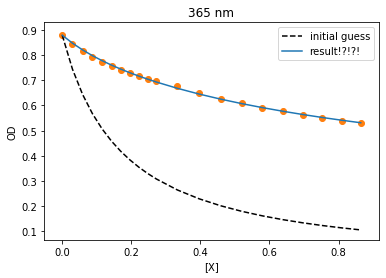

In [45]:


## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_per_wavelength(ini_guess_multi)[0], 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[0], label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_380, c='C1')
plt.title('380 nm')
plt.legend()

plt.figure()
## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_per_wavelength(ini_guess_multi)[1], 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[1], label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_400, c='C1')
plt.title('400 nm')
plt.legend()

plt.figure()
## Plot initial guess
plt.plot(
    con_X, 
    Absorbance_per_wavelength(ini_guess_multi)[2], 
    ls='--',
    c='k',
    label='initial guess')

plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[2], label='result!?!?!')

plt.xlabel('[X]')
plt.ylabel('OD')
plt.scatter(con_X, od_365, c='C1')
plt.title('365 nm')
plt.legend()


#### Fitting all wavelengths 
---
First load datas

In [ ]:
with open('all_wavelengths_PhOH.dat') as file:
    for i in range(5):
        print(file.readline())

In [ ]:
all_wavelengths = np.loadtxt(
    'all_wavelengths_PhOH.dat',
#     skiprows=1,
    usecols=range(1,502),
    delimiter='\t'
    )[0]

In [ ]:
all_wavelengths.shape

In [ ]:
all_wavelengths

In [ ]:
all_data = np.loadtxt(
    'all_wavelengths_PhOH.dat',
    skiprows=1,
    delimiter='\t'
)

In [ ]:
all_data.T

Let's trim the data a bit

In [ ]:
max_wavelength = np.argwhere(all_wavelengths == 470)[0,0]
min_wavelength = np.argwhere(all_wavelengths == 320)[0,0]

In [ ]:
all_data

In [ ]:
max_wavelength

In [ ]:
trimmed_data = all_data[:, max_wavelength:min_wavelength]

In [ ]:
trimmed_data.shape

In [ ]:
extra_trimmed_data = trimmed_data[:, range(0, 300, 2)]

In [ ]:
extra_trimmed_data.shape

Create vector of $\epsilon_N$ for every wavelength. 

(I am risking resusing variable names from the 3 wavelength example above...)

In [ ]:
def get_eps_N_per_wavelength(data):
    return np.array([od[0] for od in data.T[1:]])/con_N0

In [ ]:
test_data = extra_trimmed_data[:,70:90]

In [ ]:
eps_N_vec = get_eps_N_per_wavelength(test_data)

In [ ]:
eps_N_vec.shape

Want: 
| $\lambda$ | eps_NX | eps_NX2|
|     --      |  --      |  --      |

## Try the BIG FIT

In [ ]:
## Rewrote fit function in order to take data as arg 
def em_fit_fun(unknowns, *args):
    """ Cost function returning a vector of absorbance 
        equations at each wavelength 
        
        Args:
            unknowns 
        
        Returns: 
            vetor of length n, where n is number of 
            wavelength points determined by length of args[0] and args[1]
        
        """
    K1, K2 = unknowns[:2]
    ## Check the length of eps_N_vec
        ## 2 * len(eps_N_vec) more unknowns
        
    ## Get data from args tuple
    data = args[0]
    eps_N_vec = args[1]
    
    ## Iterate through eps_N for each wavelength
    for i, eps_N in enumerate(eps_N_vec):
    
        ## Grab other two eps's from unknown arg (vector/list)
        ## eps_NX are odd indexed
        eps_NX = unknowns[2*(i+1)]
        ## eps_NX2s are even indexed
        eps_NX2 = unknowns[2*(i+1)+1]
        
        ## Build cost function for this wavelength 
        f = (
            eps_N * con_N(K1, K2)
            + 
            eps_NX * con_NX(K1, K2) 
            +
            eps_NX2 * con_NX2(K1, K2)
            ) - data.T[i+1]
        
        ## add value of cost funtion to list
        if i is 0:
            f_tot = f
        elif i is not 0:
            f_tot = np.hstack((f_tot, f))

    return f_tot

In [ ]:
dummy_ini_guesses = [6.03599333e+00, 4.61655475e-01] + [1*1e4, 1*1e5]*19

In [ ]:
em_fit

In [ ]:
# ini_guess = [41.5, .06, 1.1, .25]
# ini_guess_multi = [6.03599333e+00, 4.61655475e-01, 1.42647085e+00, 1,1.42647085e+00, 1,1.42647085e+00, 1]

# sol = opt.root(
#     em_fun_at_380, 
#     ini_guess, 
# #     jac=jaco, 
#     method='lm',
# #     bounds=Bounds([0], [np.inf])
# )

fit_multi = opt.least_squares(
    em_fit_fun, 
    dummy_ini_guesses, 
#     jac=jaco, 
#     method='lm',
    args=(test_data, eps_N_vec),
    bounds=(0, np.inf),
    x_scale='jac'
)


In [ ]:
fit_multi

In [ ]:
def Absorbance_per_wavelength(params, *args):
    
    ## get vec of eps_N from args to count wavelengths
    eps_N_vec = args[1]
    n_wavelengths = eps_N_vec.shape[0]
    ## get data 
    data = args[0]
    
    ## em_fit_fun is length = n_wavelengths * 21
    
    em_fit_array = em_fit_fun(params, *args).reshape((n_wavelengths, 21))
    
    absorb = em_fit_array + data.T[1:]
    
    return absorb

In [ ]:
for i in range(19):
    plt.figure()
    ## Plot initial guess
    plt.plot(
        con_X, 
        Absorbance_per_wavelength(dummy_ini_guesses, test_data, eps_N_vec)[i], 
        ls='--',
        c='k',
        label='initial guess')

    plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x, test_data, eps_N_vec)[i], label='result!?!?!')

    plt.xlabel('[X]')
    plt.ylabel('OD')
    plt.scatter(con_X, test_data.T[i,:], c='C1')
#     plt.title('380 nm')
    plt.legend()

# plt.figure()
# ## Plot initial guess
# plt.plot(
#     con_X, 
#     Absorbance_per_wavelength(ini_guess_multi)[1], 
#     ls='--',
#     c='k',
#     label='initial guess')

# plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[1], label='result!?!?!')

# plt.xlabel('[X]')
# plt.ylabel('OD')
# plt.scatter(con_X, od_400, c='C1')
# plt.title('400 nm')
# plt.legend()

# plt.figure()
# ## Plot initial guess
# plt.plot(
#     con_X, 
#     Absorbance_per_wavelength(ini_guess_multi)[2], 
#     ls='--',
#     c='k',
#     label='initial guess')

# plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[2], label='result!?!?!')

# plt.xlabel('[X]')
# plt.ylabel('OD')
# plt.scatter(con_X, od_365, c='C1')
# plt.title('365 nm')
# plt.legend()


In [ ]:
for i in range(19):
    plt.figure()
    ## Plot initial guess
    plt.plot(
        con_X, 
        Absorbance_per_wavelength(dummy_ini_guesses, test_data, eps_N_vec)[i], 
        ls='--',
        c='k',
        label='initial guess')

    plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x, test_data, eps_N_vec)[i], label='result!?!?!')

    plt.xlabel('[X]')
    plt.ylabel('OD')
    plt.scatter(con_X, test_data.T[i,:], c='C1')
#     plt.title('380 nm')
    plt.legend()

# plt.figure()
# ## Plot initial guess
# plt.plot(
#     con_X, 
#     Absorbance_per_wavelength(ini_guess_multi)[1], 
#     ls='--',
#     c='k',
#     label='initial guess')

# plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[1], label='result!?!?!')

# plt.xlabel('[X]')
# plt.ylabel('OD')
# plt.scatter(con_X, od_400, c='C1')
# plt.title('400 nm')
# plt.legend()

# plt.figure()
# ## Plot initial guess
# plt.plot(
#     con_X, 
#     Absorbance_per_wavelength(ini_guess_multi)[2], 
#     ls='--',
#     c='k',
#     label='initial guess')

# plt.plot(con_X, Absorbance_per_wavelength(fit_multi.x)[2], label='result!?!?!')

# plt.xlabel('[X]')
# plt.ylabel('OD')
# plt.scatter(con_X, od_365, c='C1')
# plt.title('365 nm')
# plt.legend()
